In [44]:
from pymongo import MongoClient
from tweets_utils import *
import html2text
from langdetect import detect
import re
from html import unescape
from nlumtp.preprocessors.cleaners.whitelist import CleanChars
import time
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from operator import itemgetter
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(15,15)

In [45]:
client = MongoClient()
db = client.search_subject
real_urls_collection = db.real_urls

In [46]:
real_urls_collection.count({"txt_lang": "en", "idf_ngram": {"$size": 20}, "idf_word": {"$size": 20}})

233

In [26]:
real_urls_collection.find_one({"txt_lang": "en", "idf_ngram": {"$size": 20}}, {"idf_ngram": 1, "idf_word": 1, "txt_title":1})

{'_id': {'real_url': 'http://blogs.microsoft.com/next/2016/12/01/machine-learning-breakthroughs-abound-researchers-look-democratize-benefits/'},
 'idf_ngram': ['machine learning',
  'reinforcement learning',
  'john langford',
  'duke university',
  'artificial intelligence',
  'university of montreal',
  'the field',
  'conference on neural information processing systems',
  'the cloud',
  'robert schapire',
  'of montreal',
  'matrix completion',
  'fan yang',
  'the system',
  'stochastic gradient descent',
  'recurrent neural network',
  'parallel algorithm',
  'jeffrey miller',
  'the nips',
  'new york'],
 'idf_word': ['microsoft',
  'learning',
  'machine',
  'schapire',
  'nips',
  'reinforcement',
  'university',
  'researchers',
  'researcher',
  'langford',
  'lab',
  'systems',
  'agarwal',
  'alekh',
  'said',
  'hofmann',
  'ustc',
  'field',
  'democratize',
  'neural'],
 'txt_title': 'As machine learning breakthroughs abound, researchers look to democratize benefits - N

In [47]:
max_idf = 20

In [48]:
all_urls = real_urls_collection.find({"txt_lang": "en", "idf_ngram": {"$size": 20}}, 
                                     {"idf_ngram": 1, "idf_word": 1, "txt_title": 1})
print(all_urls.count())
words = Counter()
phrases = Counter()
clean_urls = []
for u in all_urls:
    url = u["_id"]["real_url"].split("#")[0].split("?")[0]
    if url not in [x["url"] for x in clean_urls]:
        clean_urls.append({"url": url, #u["_id"]["real_url"], 
                           "words": set(u["idf_word"][:max_idf]), 
                           "ngrams": set(u["idf_ngram"][:max_idf]),
                           "title": u["txt_title"]})
        words.update(u["idf_word"][:max_idf])
        phrases.update(u["idf_ngram"][:max_idf])

233


In [49]:
len(words)

1692

In [10]:
pd.DataFrame(phrases.most_common())[[1, 0]].to_csv("most-idf-phrases.csv", sep="\t", index=None)

In [11]:
len(clean_urls)

183

In [12]:
def dist_set(a, b, words=1, ngrams=1):
    d = 1 - (len(a["words"] & b["words"]) * words + len(a["ngrams"] & b["ngrams"]) * ngrams) \
        / ((words + ngrams) * max_idf)
    if d > 0.02:
        return 100
    else:
        return d

In [17]:
def dist_set(a, b, words=1, ngrams=1):
    d = 1 - (len(a["words"] & b["words"]) * words + len(a["ngrams"] & b["ngrams"]) * ngrams) \
        / ((words + ngrams) * max_idf)
        
    return d

In [18]:
import hdbscan
import numpy as np

In [19]:
dist_set(clean_urls[0], clean_urls[3])

0.85

In [20]:
dists = [[dist_set(a, b) for a in clean_urls] for b in clean_urls]

In [138]:
np.percentile([x for l in dists for x in l], 0.3)

0.0

In [33]:
df = pd.DataFrame([x for l in dists for x in l], columns=["lol"])

In [42]:
len(df[df.lol == 0])

187

In [41]:
df[(df.lol > 0) & (df.lol < 0.6)].sort_values("lol")

lol
29804  0.025
29076  0.025
29336  0.050
10408  0.050
21395  0.100
30677  0.100
2514   0.125
24718  0.125
3782   0.125
22346  0.125
5686   0.250
2410   0.250
24736  0.275
5808   0.275
5640   0.350
27480  0.350
14122  0.400
5750   0.400
24782  0.425
14226  0.425
2456   0.450
6420   0.450
2780   0.450
14104  0.450
19923  0.525
29205  0.525
31374  0.550
14994  0.550
20101  0.575
14092  0.575
28291  0.575
260    0.575

In [35]:
len(df)

33489

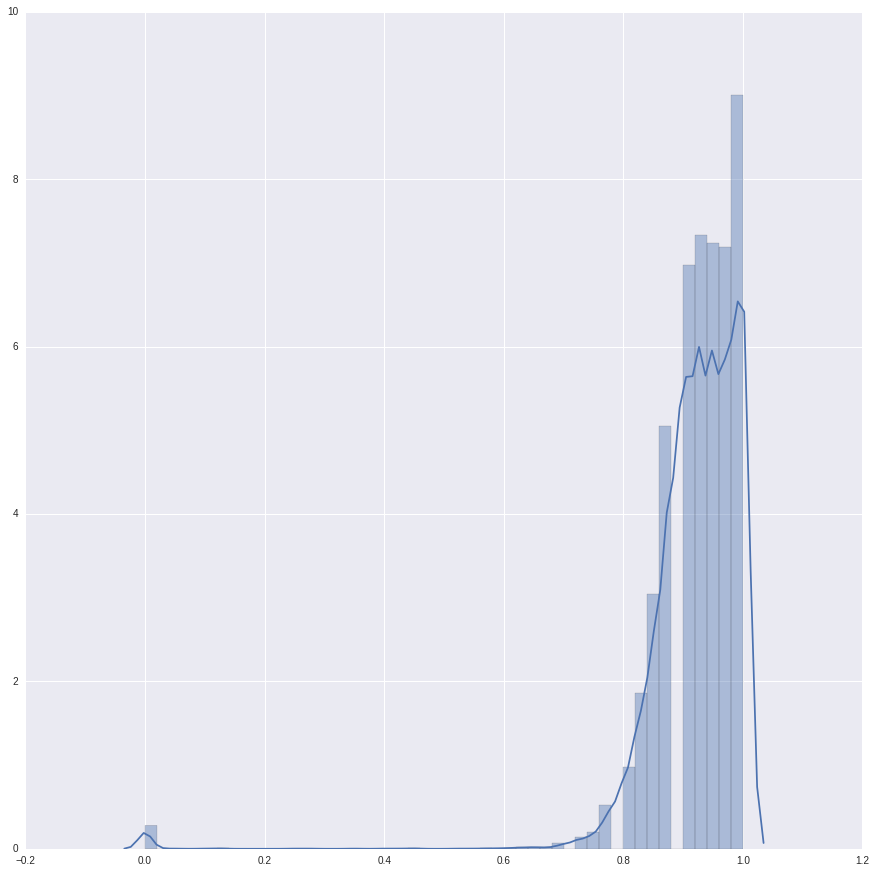

In [25]:
sns.distplot([x for l in dists for x in l])

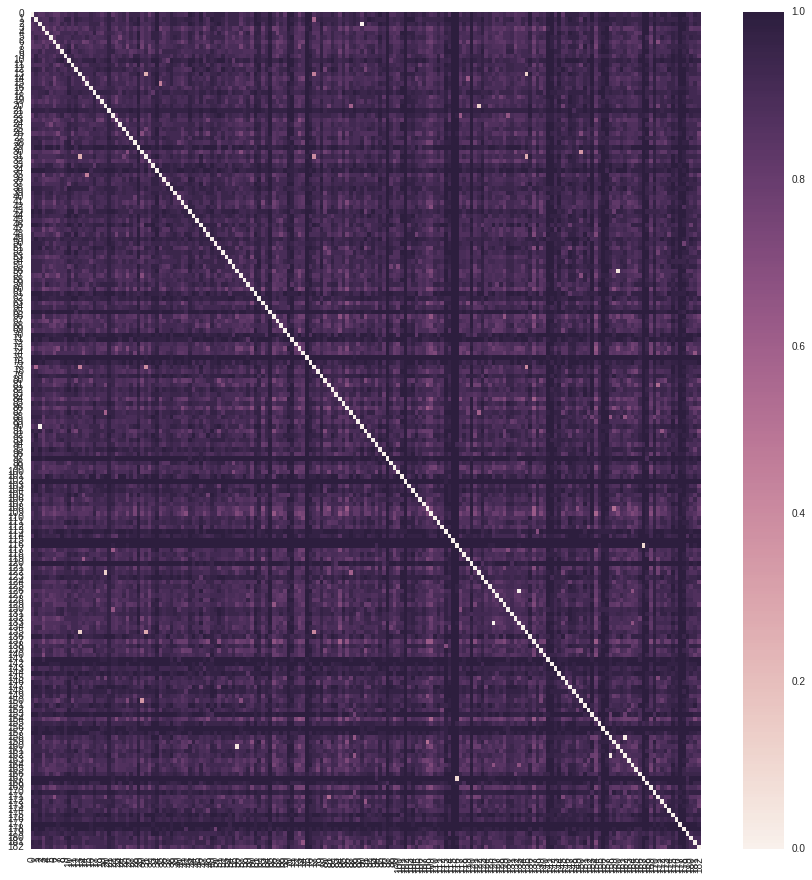

In [24]:
sns.heatmap(dists)

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3, metric="precomputed")

In [141]:
results = clusterer.fit_predict(dists)

In [142]:
r = {group: [] for group in results}    

for i, group in enumerate(results):
    #url = clean_urls[i]["url"]
    r[group].append(clean_urls[i])

In [143]:
from html import escape

In [144]:
with open("urls-cluster.html", 'w') as f:
    f.write('<p>')
    for group in r:
        if group == -1:
            continue
            
        words = set(r[group][0]["words"])
        ngrams = set(r[group][0]["ngrams"])
        for url in r[group]:
            words = words & url["words"]
            ngrams = ngrams & url["ngrams"]
        f.write("Group:{}<br/>Words: {}<br/>Ngrams: {}<br/>".format(str(group), str(words), str(ngrams)))
        for url in r[group]:
            f.write("{}<br/>&nbsp;&nbsp;&nbsp;<a href={}>{}</a><br />".format(escape(url["title"])[:100] if url["title"] is not None else "NO TITLE" , url["url"], url["url"]))
        f.write('<br/><br/><br/>')
    f.write('</p>')

In [145]:
r.keys()

dict_keys([0, 1, -1])

In [146]:
max(r)

1

In [147]:
xxx = r[1]

In [148]:
pd.DataFrame(list(zip(*[x["words"] for x in xxx])))

0             1              2           3               4    \
0            zooms   permutation    variational          ai  mathematically   
1    convolutional          cell   autoencoders   sejnowski        gaussian   
2        subregion         cells  convolutional      hinton            data   
3             code            l2            aes       brain      challenges   
4            steps      specific           daes        deep         methods   
5           object       cliques           rnns    geoffrey          kernel   
6              you       fearful            you     surpass           torch   
7   visualizations  connectivity           grus  artificial            deep   
8              vgg            l5          quite    learning            nips   
9    reinforcement      cortical           vaes    networks      profession   
10          github            et            vae       input        learning   
11    hierarchical           rsc  architectures     weights           field   
12          models      patterns       networks       cifar     uncertainty   
13            bool         units           node      neural          models   
14         weights            al            rnn     network         machine   
15     generalitat          mice      recurrent        nets          laning   
16           crops        neural        network     neurons     engineering   
17           image    excitatory         neural    machines             our   
18             upc       neurons         sample      google       processes   
19        proposal         logic  abbreviations          we              we   

            5             6             7              8               9    \
0         human          what           car    variational        software   
1           end       assumed            q2   autoencoders            data   
2      accuracy    describing   specialists        dropout          lustre   
3          data          said            ai       bayesian       marketing   
4         level        object       driving           nips             big   
5    approaches           you          nips       detector           intel   
6            dl           nlp          deep     distortion        solution   
7           you        vector  intelligence          mnist         webcast   
8            ai      language           aev    adversarial      enterprise   
9         chunk          read     automaker        anomaly  infrastructure   
10         test        trying      mobileye    classifiers          netapp   
11     learning    incidental    artificial          input       analytics   
12    flowchart             i       parking    uncertainty    applications   
13        model         often      learning         models           cloud   
14      dataset      megatron  autonomously     likelihood         netflix   
15       models          very         model         neural           cisco   
16          hpc          thia       piloted         linear      supermicro   
17  performance        tokens     maneuvers  approximation         nexenta   
18   algorithms  wittgenstein          audi             we       solutions   
19          dev         wrong       systems       datasets         storage   

       ...                 177           178              179           180  \
0      ...             framing          code     autoencoders           jnk   
1      ...                 gan            ai            arxiv           erk   
2      ...                  ai       improve       criticisms           pka   
3      ...                gans    leveraging          invited          pip2   
4      ...                  ml      leverage              you     variables   
5      ...                  am           you            brain           aci   
6      ...                 you      delivery         symposia             w   
7      ...        minimization          will             chen           mek   
8    

In [149]:
len(r)

3

In [150]:
len(r[-1])

1

In [75]:
urls_coll = client.search_subject.urls

In [76]:
urls_coll.count()

66164

In [89]:
urls_coll.count({"state": "visited"})

1093

In [81]:
urls_coll.count({"ignored_vocab": {"$exists": True}})

46445

In [94]:
real_urls_collection.count({"txt_lang": "en"})

597

In [82]:
66164 - 18490 - 46445

1229

In [26]:
clean_urls[0]

{'ngrams': {'artificial intelligence',
  'conference on neural information processing systems',
  'fire hose',
  'john langford',
  'machine learning',
  'microsoft azure',
  'microsoft edge',
  'microsoft groove',
  'microsoft hololens',
  'microsoft surface',
  'on the issues',
  'quantum computing',
  'reinforcement learning',
  'robert schapire',
  'skype for business',
  'the cloud',
  'the field',
  'the system',
  'windows phone',
  'xbox one games'},
 'url': 'http://blogs.microsoft.com/next/2016/12/01/machine-learning-breakthroughs-abound-researchers-look-democratize-benefits/',
 'words': {'agarwal',
  'apps',
  'breakthroughs',
  'brecher',
  'computing',
  'democratize',
  'hofmann',
  'lab',
  'langford',
  'learning',
  'machine',
  'microsoft',
  'nips',
  'reinforcement',
  'researcher',
  'researchers',
  'schapire',
  'systems',
  'windows',
  'xbox'}}

In [170]:
real_urls_collection.find_one({"_id": {"real_url": { "$regex" : r"/^http/" }}})

In [172]:
random_doc(real_urls_collection)

{'_id': {'real_url': 'https://tryolabs.com/blog/2016/12/06/major-advancements-deep-learning-2016/#disqus_thread'},
 'count': 2,
 'filename': '8189685171289063771.html',
 'first_tweet_date': 'Fri Dec 09 02:53:49 +0000 2016',
 'idf_ngram': ['unsupervised learning',
  'machine learning',
  'deep learning',
  'the question',
  'yann lecun',
  'multilayer perceptron',
  'has been',
  'art forgery',
  'open source',
  'for free',
  'dimensionality reduction',
  'question answering',
  'supervised learning',
  'training set',
  'great year',
  'open platform',
  'target language',
  'learning community',
  'data compression',
  'natural language processing'],
 'idf_ngram_weights': [32.34997413186491,
  31.731574006471693,
  31.55191240485311,
  20.488151180012366,
  12.492846081612722,
  12.218409235910961,
  11.485560127148874,
  11.376842050232742,
  11.20030201758611,
  10.840044987968378,
  10.802556072549525,
  10.440072787015048,
  10.21153838706596,
  9.82051396311259,
  9.697492148599

In [171]:
real_urls_collection.find_one({"filename": "259954082082805890.html"})

{'_id': {'real_url': 'http://linkis.com/ift.tt/oQHnR'},
 'count': 1,
 'error': 'no content extracted',
 'filename': '259954082082805890.html',
 'first_tweet_date': 'Tue Dec 13 16:36:14 +0000 2016',
 'last_tweet_date': 'Tue Dec 13 16:36:14 +0000 2016',
 'most_common_words': ['00',
  '2016',
  '12',
  'to',
  '06',
  'am',
  '47',
  'open',
  '08',
  'linkis',
  '13',
  '05',
  'pm',
  '51',
  'be',
  'page',
  'twitter',
  'authorize',
  'with',
  '15'],
 'most_common_words_count': [15,
  11,
  10,
  6,
  4,
  3,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 'retweet_count': 0,
 'search_queries': ['nips2016'],
 'state': 'bowed2',
 'texts': ['r nips 2016 overviews via r machinelearning'],
 'tweet_expanded_urls': ['http://ln.is/ift.tt/oQHnR'],
 'txt_lang': None,
 'txt_len': 0,
 'txt_title': '[R] NIPS 2016 Overviews : MachineLearning - Linkis.com'}